Autor:

* Mateusz Jastrząb
* matteuszj@gmail.com

### 1. Import niezbędnych bibliotek

In [21]:
import warnings
from typing import Union, List, Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

from fancyimpute import KNN
import category_encoders as ce

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#### Deklaracja stałych i funkcji.

In [3]:
RANDOM_STATE: int = 20190506
TEST_SIZE: float = 0.20

In [4]:
def rmse(y_test: Union[np.ndarray, pd.Series],
         y_pred: Union[np.ndarray, pd.Series]) -> float:
    
    return np.sqrt(np.mean((y_test-y_pred)**2))

def mean_absolute_percentage_error(y_test: Union[np.ndarray, pd.Series],
                                   y_pred: Union[np.ndarray, pd.Series]) -> float:
    
    y_true, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 2. Wczytanie zbioru danych

In [5]:
dataset: pd.DataFrame = pd.read_json("./public-dataset.json").reset_index(drop=True)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853 entries, 0 to 7852
Data columns (total 17 columns):
buynow_price                         7853 non-null float64
rodzaj karty graficznej              7357 non-null object
komunikacja                          7071 non-null object
rozdzielczość (piksele)              7245 non-null object
liczba rdzeni procesora              7853 non-null object
wielkość pamięci ram                 7403 non-null object
system operacyjny                    7203 non-null object
typ dysku twardego                   7418 non-null object
sterowanie                           7175 non-null object
multimedia                           7145 non-null object
typ pamięci ram                      6989 non-null object
taktowanie bazowe procesora (ghz)    6917 non-null float64
seria procesora                      7320 non-null object
stan                                 7853 non-null object
pojemność dysku (gb)                 7372 non-null float64
gwarancja           

#### Usuwam obserwacje mające więcej niż 50% nulli spośród wszystkich zmiennych

In [7]:
dataset = dataset.loc[dataset.isnull().sum(axis=1)/(dataset.shape[1]-1) <= 0.5,:].reset_index(drop=True)

### 3. EDA

#### 3.1 Analiza istniejących zmiennych

#### 3.1.1 buynow_price

Text(0.5, 1.0, 'Buynow Price density plot')

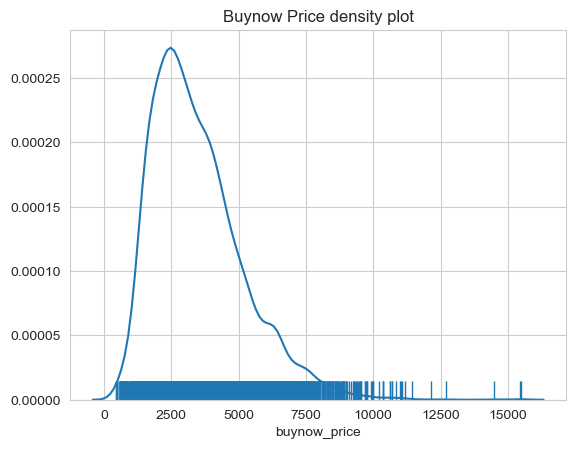

In [86]:
sns.set_style("whitegrid")
sns.distplot(dataset.buynow_price, rug=True, hist=False).set_title('Buynow Price density plot')

In [87]:
dataset.buynow_price.skew()

1.1174547268133959

In [88]:
dataset.buynow_price.describe()

count     7485.000000
mean      3476.154823
std       1683.830877
min        429.000000
25%       2239.000000
50%       3173.000000
75%       4389.000000
max      15472.650000
Name: buynow_price, dtype: float64

##### Wniosek: Zmienna zależna jest lekko skośna, obecność outlierów.

#### 3.1.2 rodzaj karty graficznej

Text(0.5, 1.0, 'GPU type vs price violinplots')

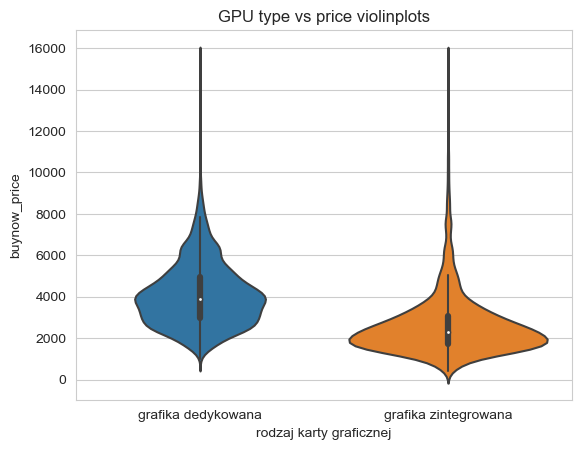

In [91]:
sns.violinplot(
    x=dataset['rodzaj karty graficznej'],
    y=dataset['buynow_price']
    ).set_title("GPU type vs price violinplots")

In [92]:
dataset['rodzaj karty graficznej'].value_counts()

grafika dedykowana      4323
grafika zintegrowana    3010
Name: rodzaj karty graficznej, dtype: int64

##### Wniosek: Oba poziomy rodzaju karty graficznej mają wystarczające liczebności, wyższa mediana ceny występuje z grafiką dedykowaną.

#### 3.1.3 Komunikacja

##### Charakter zmiennej, wymaga dodatkowego przekształecenia, polegającego na rozstrzeleniu wartości komórek na kolumny.

In [93]:
def explode(dataframe, column, target='buynow_price'):
    rows = []
    temp_df = dataframe.loc[:, [column]].reset_index()
    temp_df = temp_df.dropna()
    for i, row in temp_df.iterrows():
        for a in row[column]:
            rows.append([a, row['index']])
            
    result = pd.DataFrame(rows, columns=[column, 'index'])
    result['values'] = 1
    result = result.pivot(index='index', columns=column, values='values')
    
    joined = dataset[target].to_frame(str(target)).join(result, how='left').fillna(0)
    return joined

In [94]:
komunikacja_pivot_df = explode(dataset, 'komunikacja')

In [95]:
komunikacja_pivot_df.mean()

buynow_price                      3476.154823
bluetooth                            0.871610
gps                                  0.035939
intel wireless display (widi)        0.134135
lan 10/100 mbps                      0.373681
lan 10/100/1000 mbps                 0.529192
modem 3g (wwan)                      0.134803
modem 4g (lte)                       0.035671
nfc (near field communication)       0.194255
wi-fi                                0.395190
wi-fi 802.11 a/b/g/n                 0.002271
wi-fi 802.11 a/b/g/n/ac              0.019105
wi-fi 802.11 b/g/n                   0.009753
wi-fi 802.11 b/g/n/ac                0.022044
dtype: float64

In [96]:
komunikacja_pivot_df.head(2)

,buynow_price,bluetooth,gps,intel wireless display (widi),lan 10/100 mbps,lan 10/100/1000 mbps,modem 3g (wwan),modem 4g (lte),nfc (near field communication),wi-fi,wi-fi 802.11 a/b/g/n,wi-fi 802.11 a/b/g/n/ac,wi-fi 802.11 b/g/n,wi-fi 802.11 b/g/n/ac
0,5524.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1720.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### Niektóre poziomy występują całkiem rzadko, dlatego można połączyć kilka w jeden.

In [97]:
komunikacja_pivot_df['wi_fi'] = np.where(
    komunikacja_pivot_df['wi-fi'] + \
    komunikacja_pivot_df['wi-fi 802.11 a/b/g/n'] + \
    komunikacja_pivot_df['wi-fi 802.11 a/b/g/n/ac'] + \
    komunikacja_pivot_df['wi-fi 802.11 b/g/n'] + \
    komunikacja_pivot_df['wi-fi 802.11 b/g/n/ac'] >= 1, 1, 0
    )

komunikacja_pivot_df['lan'] = np.where(
    komunikacja_pivot_df['lan 10/100 mbps'] + \
    komunikacja_pivot_df['lan 10/100/1000 mbps'] >= 1, 1, 0
    )

komunikacja_pivot_df['modem'] = np.where(
    komunikacja_pivot_df['modem 3g (wwan)'] + \
    komunikacja_pivot_df['modem 4g (lte)'] >= 1, 1, 0
    )

komunikacja_pivot_df = komunikacja_pivot_df.drop(
    columns=[
        'wi-fi',
        'wi-fi 802.11 a/b/g/n',
        'wi-fi 802.11 a/b/g/n/ac',
        'wi-fi 802.11 b/g/n',
        'wi-fi 802.11 b/g/n/ac',
        'lan 10/100 mbps',
        'lan 10/100/1000 mbps',
        'modem 3g (wwan)',
        'modem 4g (lte)'
    ], axis=1
    )

In [98]:
komunikacja_pivot_df.mean()

buynow_price                      3476.154823
bluetooth                            0.871610
gps                                  0.035939
intel wireless display (widi)        0.134135
nfc (near field communication)       0.194255
wi_fi                                0.446359
lan                                  0.784235
modem                                0.147762
dtype: float64

##### Wprowadzam nową zmienną, będącą sumą elementów z grupy komunikacja.

In [99]:
komunikacja_pivot_df['communication_number'] = komunikacja_pivot_df['bluetooth'] + \
    komunikacja_pivot_df['gps'] + \
    komunikacja_pivot_df['intel wireless display (widi)'] + \
    komunikacja_pivot_df['nfc (near field communication)'] + \
    komunikacja_pivot_df['wi_fi'] + \
    komunikacja_pivot_df['lan'] + \
    komunikacja_pivot_df['modem']

Text(0.5, 1.0, 'Communication number vs price boxplots')

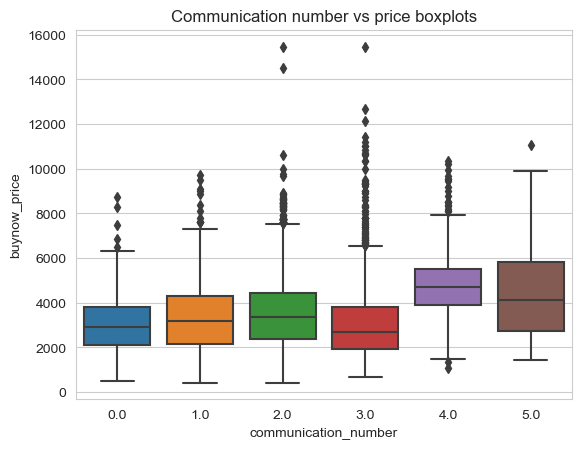

In [100]:
sns.boxplot(
    x=komunikacja_pivot_df.communication_number,
    y=komunikacja_pivot_df.buynow_price
    ).set_title("Communication number vs price boxplots")

#### 3.1.4 rozdzielczość (piksele)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

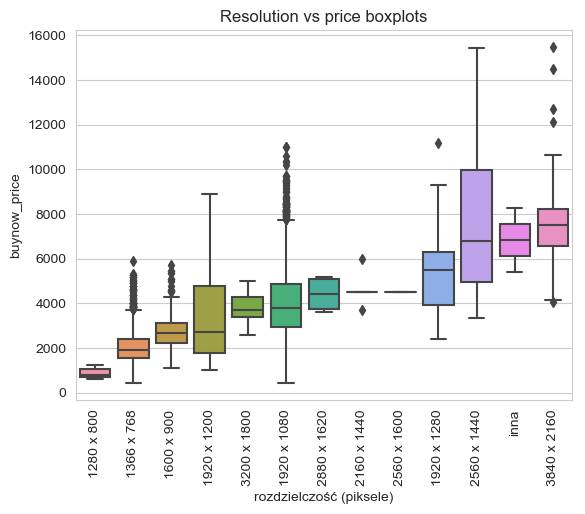

In [455]:
sns.boxplot(
    x=dataset['rozdzielczość (piksele)'],
    y=dataset['buynow_price'],
    order=dataset.groupby('rozdzielczość (piksele)').median().sort_values('buynow_price').index
    ).set_title("Resolution vs price boxplots")

plt.xticks(rotation=90)

In [456]:
dataset['rozdzielczość (piksele)'].value_counts()

1920 x 1080    4546
1366 x 768     2099
1600 x 900      363
3840 x 2160     123
2560 x 1440      34
1920 x 1280      31
1280 x 800       16
3200 x 1800      15
2160 x 1440       5
2880 x 1620       4
1920 x 1200       4
inna              2
2560 x 1600       1
Name: rozdzielczość (piksele), dtype: int64

##### Następne kroki: Łączenie poziomów mających mniej niż 5 obserwacji, encoding.

#### 3.1.5 liczba rdzeni procesora

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

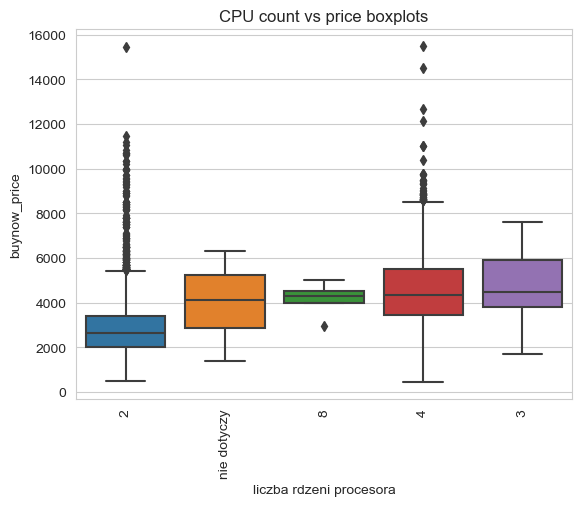

In [111]:
sns.boxplot(
    x=dataset['liczba rdzeni procesora'],
    y=dataset['buynow_price'],
    order=dataset.groupby('liczba rdzeni procesora').median().sort_values('buynow_price').index
    ).set_title("CPU count vs price boxplots")
plt.xticks(rotation=90)

In [117]:
dataset['liczba rdzeni procesora'].value_counts()

2              4550
4              2845
3                81
8                 5
nie dotyczy       4
Name: liczba rdzeni procesora, dtype: int64

#### 3.1.6 wielkość pamięci ram

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

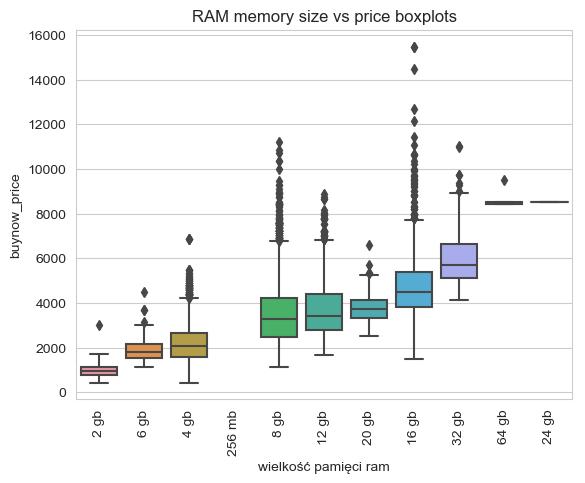

In [122]:
sns.boxplot(
    x=dataset['wielkość pamięci ram'].replace('256 mb', '0.256 gb'),
    y=dataset['buynow_price'],
    order=dataset.groupby('wielkość pamięci ram').median().sort_values('buynow_price').index
    ).set_title("RAM memory size vs price boxplots")
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Numeric RAM memory size density plot')

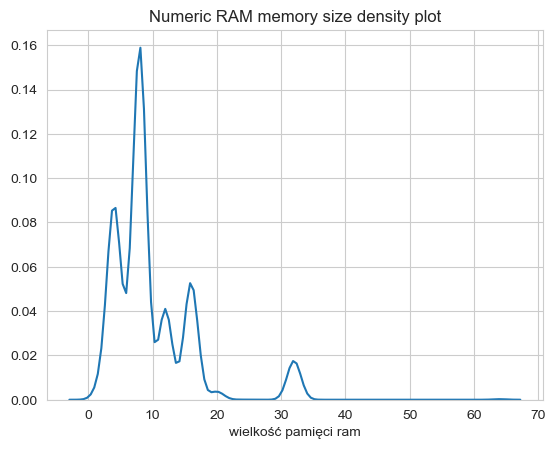

In [124]:
sns.distplot(
    dataset['wielkość pamięci ram'].replace('256 mb', '0.256 gb').str.strip('gb').astype('float').dropna(),
    hist=False
    ).set_title("Numeric RAM memory size density plot")

In [127]:
dataset['wielkość pamięci ram'].value_counts()

8 gb      3114
4 gb      1710
16 gb     1046
12 gb      786
32 gb      347
6 gb       132
2 gb       126
20 gb       72
64 gb        5
24 gb        1
256 mb       1
Name: wielkość pamięci ram, dtype: int64

In [457]:
dataset.loc[dataset['wielkość pamięci ram']=='256 mb', :]

,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy
4584,3199.0,grafika zintegrowana,"[bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,256 mb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,NaN,intel core i5,nowy,256.0,producenta,"15"" - 15.9"""


#### 256 mb DDR raczej jest mało prawdopodobne.

In [8]:
dataset.loc[dataset['wielkość pamięci ram']=='256 mb', 'wielkość pamięci ram'] = np.nan

#### Wniosek: Zamiana na zmienną numeryczną raczej może nie pomóc, ze wględu na wielomodalny rozkład. Złączenie 24 gb i 64 gb w jeden poziom.

#### 3.1.7 system operacyjny

#### Podobna sytuacja, jak w przypadku komunikacji.

In [149]:
system_pivot_df = explode(dataset, 'system operacyjny')

In [121]:
system_pivot_df.mean()

buynow_price                       3476.154823
brak systemu                          0.176219
inny                                  0.052772
linux                                 0.000267
windows 10 home                       0.546426
windows 10 professional               0.185972
windows 7 home 64-bit                 0.000534
windows 7 professional 32-bit         0.000401
windows 7 professional 64-bit         0.033534
windows 8.1 home 32-bit               0.001870
windows 8.1 home 64-bit               0.018170
windows 8.1 professional 32-bit       0.000401
windows 8.1 professional 64-bit       0.002806
dtype: float64

In [150]:
system_pivot_df['inny_brak_linux'] = np.where(
    system_pivot_df['brak systemu'] + \
    system_pivot_df['inny'] + \
    system_pivot_df['linux'] >= 1, 1, 0
    )

system_pivot_df['windows_7_8'] = np.where(
    system_pivot_df['windows 7 home 64-bit'] + \
    system_pivot_df['windows 7 professional 32-bit'] + \
    system_pivot_df['windows 7 professional 64-bit'] + \
    system_pivot_df['windows 8.1 home 32-bit'] + \
    system_pivot_df['windows 8.1 home 64-bit'] + \
    system_pivot_df['windows 8.1 professional 32-bit'] + \
    system_pivot_df['windows 8.1 professional 64-bit'] >= 1, 1, 0
    )

system_pivot_df = system_pivot_df.drop(
    columns=[
        'brak systemu',
        'inny',
        'linux',
        'windows 7 home 64-bit',
        'windows 7 professional 32-bit',
        'windows 7 professional 64-bit',
        'windows 8.1 home 32-bit',
        'windows 8.1 home 64-bit',
        'windows 8.1 professional 32-bit',
        'windows 8.1 professional 64-bit'
    ], axis=1)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

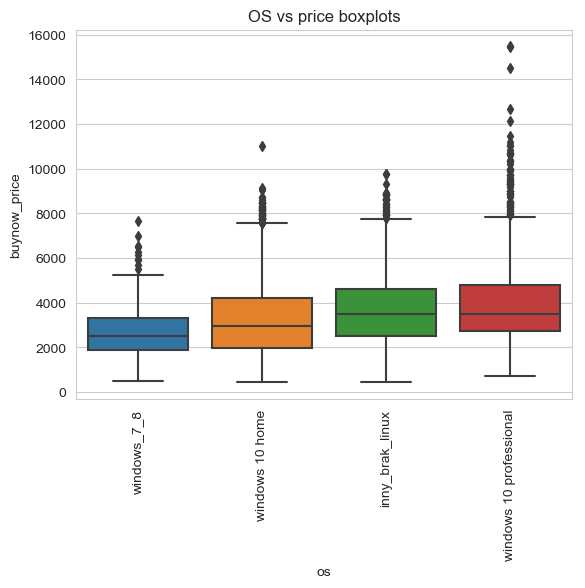

In [162]:
sns.boxplot(
    data=pd.melt(system_pivot_df, id_vars='buynow_price').query('value==1.0').rename(columns={'variable':'os'}),
    x='os',
    y='buynow_price',
    order=['windows_7_8', 'windows 10 home', 'inny_brak_linux', 'windows 10 professional']
).set_title("OS vs price boxplots")

plt.xticks(rotation=90)

In [152]:
system_pivot_df.mean()

buynow_price               3476.154823
windows 10 home               0.546426
windows 10 professional       0.185972
inny_brak_linux               0.229259
windows_7_8                   0.056112
dtype: float64

#### Wniosek: Złączenie poziomów + encoding.

#### 3.1.8 typ dysku twardego

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

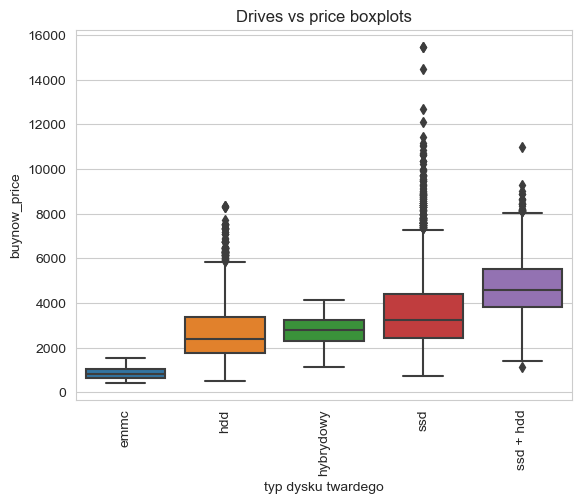

In [463]:
sns.boxplot(
    x=dataset['typ dysku twardego'],
    y=dataset['buynow_price'],
    order=dataset.groupby('typ dysku twardego').median().sort_values('buynow_price').index
).set_title("Drives vs price boxplots")
plt.xticks(rotation=90)

In [717]:
dataset['typ dysku twardego'].value_counts()

ssd          3759
hdd          2320
ssd + hdd    1146
emmc           91
hybrydowy      86
Name: typ dysku twardego, dtype: int64

#### 3.1.9 sterowanie

In [467]:
sterowanie_pivot_df = explode(dataset, 'sterowanie')

In [468]:
sterowanie_pivot_df.mean()

buynow_price               3476.154823
klawiatura                    0.900067
klawiatura numeryczna         0.457983
klawiatura podświetlana       0.348297
touchpad                      0.948029
dtype: float64

#### 3.1.10 multimedia

In [465]:
multimedia_pivot_df = explode(dataset, 'multimedia')

In [466]:
multimedia_pivot_df.mean()

buynow_price            3476.154823
czytnik kart pamięci       0.901002
głośniki                   0.881363
kamera                     0.938677
mikrofon                   0.887108
dtype: float64

#### 3.1.11 typ pamięci ram

Text(0.5, 1.0, 'RAM type vs price boxplots')

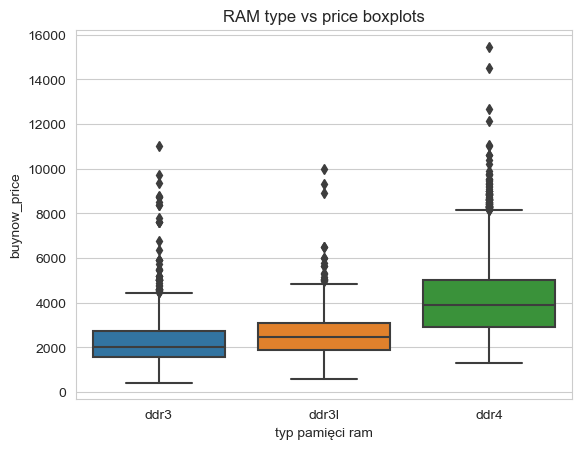

In [471]:
sns.boxplot(
    x=dataset['typ pamięci ram'],
    y=dataset['buynow_price'],
    order=dataset.groupby('typ pamięci ram').median().sort_values('buynow_price').index
).set_title("RAM type vs price boxplots")

In [472]:
dataset['typ pamięci ram'].value_counts()

ddr4     4532
ddr3     1769
ddr3l     687
Name: typ pamięci ram, dtype: int64

#### 3.1.12 taktowanie bazowe procesora (ghz)

Text(0.5, 1.0, 'CPU ghz density plot')

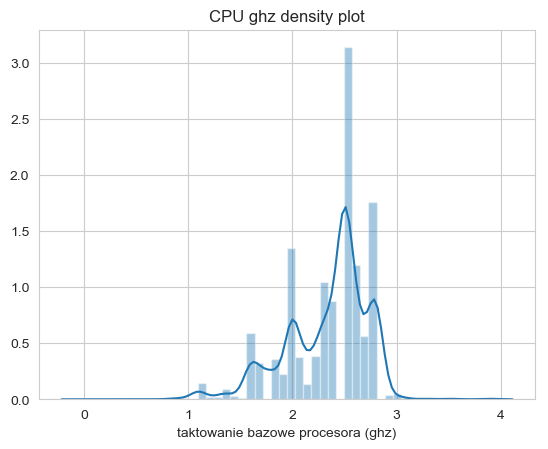

In [504]:
sns.distplot(
    dataset['taktowanie bazowe procesora (ghz)'].dropna(),
).set_title("CPU ghz density plot")

In [724]:
dataset['taktowanie bazowe procesora (ghz)'].skew()

-0.884764952086726

#### Wniosek: Rozkład wielomodalny, raczej wymaga interakcji z innymi zmiennymi opisującymi CPU

#### 3.1.13 seria procesora

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

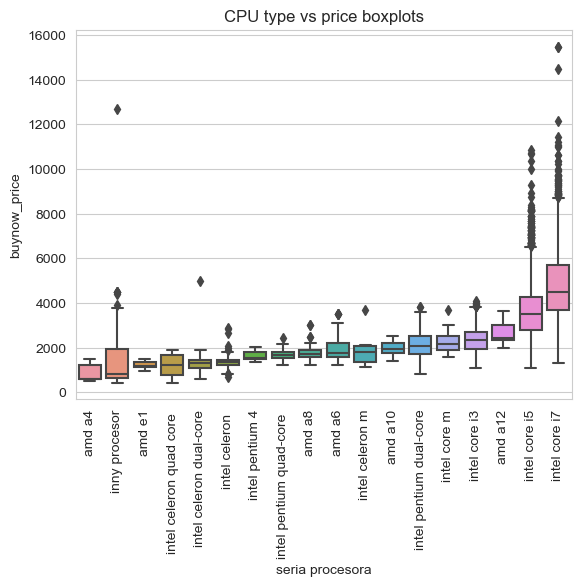

In [510]:
sns.boxplot(
    x=dataset['seria procesora'],
    y=dataset['buynow_price'],
    order=dataset.groupby('seria procesora').median().sort_values('buynow_price').index
    ).set_title("CPU type vs price boxplots")
plt.xticks(rotation=90)

In [509]:
dataset['seria procesora'].value_counts()

intel core i5               2592
intel core i7               2319
intel core i3               1398
amd a6                       194
intel pentium dual-core      174
intel celeron dual-core      170
intel celeron                116
intel pentium quad-core       87
inny procesor                 66
amd a8                        42
amd a10                       29
intel celeron quad core       27
amd e1                        22
amd a12                       21
intel pentium 4               15
intel core m                  12
amd a4                        11
intel celeron m                6
Name: seria procesora, dtype: int64

#### Każdy poziom ma co najmniej 5 obserwacji, może zostać as-is.

#### 3.1.14 stan

In [727]:
dataset['stan'].value_counts()

nowy    7485
Name: stan, dtype: int64

#### Można wykluczyć, bo zerowa wariancja.

#### 3.1.15 pojemność dysku (gb)

Text(0.5, 1.0, 'Drive type vs drive capacity boxplots')

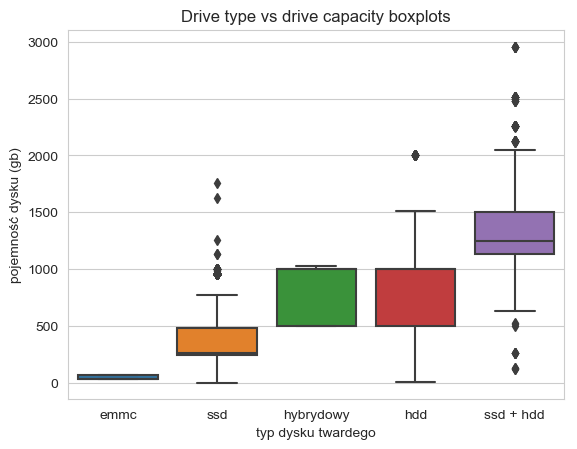

In [524]:
sns.boxplot(
    x=dataset['typ dysku twardego'], 
    y=dataset['pojemność dysku (gb)'],
    order = ['emmc', 'ssd', 'hybrydowy', 'hdd', 'ssd + hdd']
).set_title('Drive type vs drive capacity boxplots')

In [530]:
dataset['typ dysku twardego'].value_counts()

ssd          3759
hdd          2320
ssd + hdd    1146
emmc           91
hybrydowy      86
Name: typ dysku twardego, dtype: int64

##### Istnieje obserwacja o bardzo dużej pojemności hdd.

In [521]:
dataset.loc[dataset['pojemność dysku (gb)']==10000, :]

,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy
7281,4597.0,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,16 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.6,intel core i7,nowy,10000.0,producenta,"15"" - 15.9"""


#### 10 TB to raczej pomyłka, dlatego nulluje komórkę.

In [10]:
dataset.loc[dataset['pojemność dysku (gb)']==10000, 'pojemność dysku (gb)'] = np.nan

#### 3.1.16 gwarancja

Text(0.5, 1.0, 'Warranty type vs price boxplots')

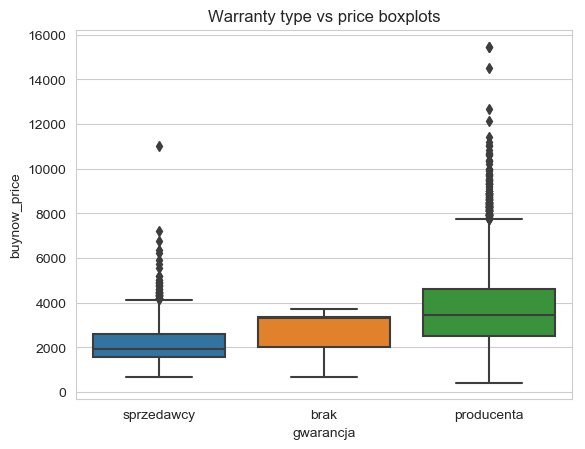

In [525]:
sns.boxplot(
    x=dataset['gwarancja'],
    y=dataset['buynow_price'],
    order=dataset.groupby('gwarancja').median().sort_values('buynow_price').index
).set_title('Warranty type vs price boxplots')

In [526]:
dataset['gwarancja'].value_counts()

producenta    6324
sprzedawcy    1156
brak             5
Name: gwarancja, dtype: int64

#### Co ciekawe, brak gwarancji ma średnio wyższy poziom cenowy niż gwarancja sprzedawcy. Natomiast takich obserwacji jest stosunkowo niewiele.

#### 3.1.17 wielkość matrycy

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

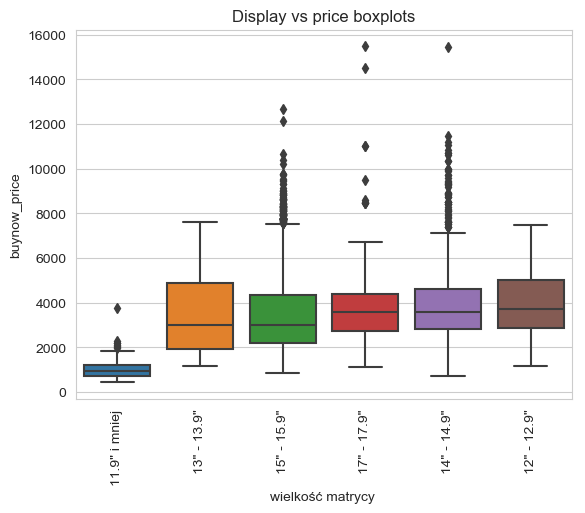

In [546]:
sns.boxplot(
    x=dataset['wielkość matrycy '],
    y=dataset['buynow_price'],
    order=dataset.groupby('wielkość matrycy ').median().sort_values('buynow_price').index
    ).set_title('Display vs price boxplots')
plt.xticks(rotation=90)

In [528]:
dataset['wielkość matrycy '].value_counts()

15" - 15.9"      5256
14" - 14.9"       881
17" - 17.9"       838
13" - 13.9"       208
11.9" i mniej     150
12" - 12.9"        93
Name: wielkość matrycy , dtype: int64

### 4. Feature Engineering

#### 4.1.1 Kroki:

Ogólne:
1. Transformacja zagnieżdżonych kolumn.
2. Rekodowanie poziomów wybranych zmiennych.
3. Kodowanie zmiennych kategorycznych.
4. Standaryzacja.
5. Imputacja nulli algorytmem KNN.
6. Stworzenie nowych zmiennych.
7. Wybór modelu.
8. Tuning hiperparametrów.


Co, do zmiennych:
1. **buynow_price**: zostaje jak jest,
2. **rodzaj karty graficznej**: encoding,
3. **komunikacja**: explode + łączenie poziomów + encoding + nowa zmienna,
4. **rozdzielczość (piksele)**: łączenie poziomów + encoding,
5. **liczba rdzeni procesora**: encoding,
6. **wielkość pamięci ram**: wykasowanie komórki z 256 mb, encoding.
7. **system operacyjny**: explode + łączenie poziomów + encoding,
8. **typ dysku twardego**: encoding,
9. **sterowanie**: explode + łączenie poziomów + encoding,
10. **multimedia**: explode + łączenie poziomów + encoding,
11. **typ pamięci ram**: encoding,
12. **taktowanie bazowe procesora (ghz)**: encoding,
13. **seria procesora**: encoding,
14. **stan**: do wyrzucenia,
15. **pojemność dysku (gb)**: wykasowanie komórki z 10 TB, encoding,
16. **gwarancja**: encoding,
17. **wielkość matrycy**: encoding.

In [13]:
class TransformedData(BaseEstimator, TransformerMixin):

    def __init__(self, cols_to_explode: List[str] = None, target: str = 'buynow_price'):
        self.cols_to_explode = cols_to_explode
        self.target = target

    @staticmethod
    def explode(dataframe_input: pd.DataFrame, column: str) -> pd.DataFrame:
        """
        Function untangling list contained in one cell to n columns.

        Args:
            dataframe_input: pandas DataFrame with input data.
            column: column to perform operation.

        Returns:
            x: pandas DataFrame with n extra columns, where n stands for unique levels in tangled column.

        """
        rows: List = []
        temp_df: pd.DataFrame = dataframe_input.loc[:, [column]].reset_index()
        temp_df = temp_df.dropna()
        for i, row in temp_df.iterrows():
            for a in row[column]:
                rows.append([a, row['index']])

        result: pd.DataFrame = pd.DataFrame(rows, columns=[column, 'index'])
        result['values'] = 1
        result = result.pivot(index='index', columns=column, values='values').fillna(0)

        return result

    @staticmethod
    def convert_to_flag(value: float) -> np.ndarray:
        return np.where(value > 0, 1, 0)

    def extract_nested_columns(self, dataframe_input: pd.DataFrame) -> pd.DataFrame:
        """
        Function combining selected levels together.

        Args:
            dataframe_input: pandas DataFrame with inital data.

        Returns:
            result: pandas DataFrame with levels combined.

        """

        result: pd.DataFrame = dataframe_input.index.to_frame(name='index')

        for col in self.cols_to_explode:
            result = result.join(self.explode(dataframe_input, col), how='left')

        joined_columns: List[str] = [
            'wi-fi',
            'wi-fi 802.11 a/b/g/n',
            'wi-fi 802.11 a/b/g/n/ac',
            'wi-fi 802.11 b/g/n',
            'wi-fi 802.11 b/g/n/ac',
            'lan 10/100 mbps',
            'lan 10/100/1000 mbps',
            'modem 3g (wwan)',
            'modem 4g (lte)',
            'brak systemu',
            'inny',
            'linux',
            'windows 7 home 64-bit',
            'windows 7 professional 32-bit',
            'windows 7 professional 64-bit',
            'windows 8.1 home 32-bit',
            'windows 8.1 home 64-bit',
            'windows 8.1 professional 32-bit',
            'windows 8.1 professional 64-bit'
        ]

        for col in joined_columns:
            if col not in result:
                result[col] = 0

        result['wi_fi'] = result[[
            'wi-fi',
            'wi-fi 802.11 a/b/g/n',
            'wi-fi 802.11 a/b/g/n/ac',
            'wi-fi 802.11 b/g/n',
            'wi-fi 802.11 b/g/n/ac'
        ]] \
            .sum(axis=1) \
            .apply(self.convert_to_flag)

        result['lan'] = result[['lan 10/100 mbps', 'lan 10/100/1000 mbps']].sum(axis=1).apply(self.convert_to_flag)

        result['modem'] = result[['modem 3g (wwan)', 'modem 4g (lte)']].sum(axis=1).apply(self.convert_to_flag)

        result['inny_brak_linux'] = result[['brak systemu', 'inny', 'linux']].sum(axis=1).apply(self.convert_to_flag)

        result['windows_7_8'] = result[[
            'windows 7 home 64-bit',
            'windows 7 professional 32-bit',
            'windows 7 professional 64-bit',
            'windows 8.1 home 32-bit',
            'windows 8.1 home 64-bit',
            'windows 8.1 professional 32-bit',
            'windows 8.1 professional 64-bit'
        ]] \
            .sum(axis=1) \
            .apply(self.convert_to_flag)

        result = result.drop(columns=joined_columns, axis=1)

        return result.reset_index().fillna(0).astype('int')

    def extract_numeric(self, dataframe_input: pd.DataFrame) -> pd.DataFrame:
        try:
            return dataframe_input.select_dtypes('number').drop(self.target, axis=1)
        except KeyError:
            return dataframe_input.select_dtypes('number')

    def extract_categorical(self, dataframe_input: pd.DataFrame) -> pd.DataFrame:

        categorical_columns: pd.Index = dataframe_input.select_dtypes('object').columns
        categorical_columns = [col for col in categorical_columns if col not in self.cols_to_explode]
        return dataframe_input.loc[:, categorical_columns]

    def fit(self) -> 'TransformedData':
        return self

    def transform(self, dataframe_input: pd.DataFrame) -> pd.DataFrame:

        result: pd.DataFrame = dataframe_input.index \
            .to_frame(name='index') \
            .join(self.extract_numeric(dataframe_input), how='left', on='index') \
            .join(self.extract_categorical(dataframe_input), how='left', on='index')

        result = result.merge(self.extract_nested_columns(dataframe_input), how='left', on='index')

        return result.drop(['index', 'level_0'], axis=1)

In [14]:
class NewFeaturesTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self) -> 'NewFeaturesTransformer':
        return self

    @staticmethod
    def transform(dataframe_input: pd.DataFrame) -> pd.DataFrame:
        """
        Function adding new variables to the input dataframe.
        
        Args:
            dataframe_input: pandas dataframe to be extended.

        Returns:
            result: pandas DataFrame to be extended.

        """
        result: pd.DataFrame = dataframe_input.copy()

        result['liczba_komunikacja'] = result[[
            'bluetooth',
            'gps',
            'intel wireless display (widi)',
            'nfc (near field communication)',
            'wi_fi',
            'lan',
            'modem'
        ]].sum(axis=1)

        result['cores_x_cpu'] = result['liczba rdzeni procesora'] * result['seria procesora']
        result['cores_x_ghz'] = result['liczba rdzeni procesora'] * result['taktowanie bazowe procesora (ghz)']
        result['cpu_x_ghz'] = result['seria procesora'] * result['taktowanie bazowe procesora (ghz)']
        result['cores_x_cpu_x_ghz'] = result['liczba rdzeni procesora'] * result['seria procesora'] * \
                                      result['taktowanie bazowe procesora (ghz)']

        result['memory_x_ram'] = result['wielkość pamięci ram'] * result['typ pamięci ram']
        result['drive_x_capacity'] = result['typ dysku twardego'] * result['pojemność dysku (gb)']

        result['ghz_sq'] = result['taktowanie bazowe procesora (ghz)'] ** 2

        result['capacity_sq'] = result['pojemność dysku (gb)'] ** 2

        return result

In [15]:
class CategoricalRecoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self) -> 'CategoricalRecoder':
        return self

    @staticmethod
    def recode_resolution(value: str) -> str:

        if value in ('2880 x 1620', '1920 x 1200', 'inna', '2560 x 1600'):
            return 'inna'
        else:
            return value

    def transform(self, dataframe_input: pd.DataFrame) -> pd.DataFrame:
        """
        Method recoding levels of categorical variables.

        Args:
            dataframe_input: pandas DataFrame.

        Returns:
            result: pandas DataFrame with recoded selected categorical levels.

        """
        result: pd.DataFrame = dataframe_input.copy()

        result['recoded_resolution'] = result['rozdzielczość (piksele)'].apply(self.recode_resolution)
        result = result.drop('rozdzielczość (piksele)', axis=1)
        return result


In [16]:
class PandasScalerImputer(BaseEstimator, TransformerMixin):
    """
    Class implemented to return pandas DataFrame after scaling or imputing, because standard scikit learn
        classed do not.
    """

    def __init__(self, obj):
        self.obj = obj

    def fit(self, dataframe_input: pd.DataFrame, y: Union[np.ndarray, pd.Series] = None, *args, **kwargs) -> None:

        if self.obj.__class__.__name__ == 'KNN':
            self.fit_transform(dataframe_input, y, *args, **kwargs)
        else:
            self.obj.fit(dataframe_input)
        return None

    def transform(self,
                  dataframe_input: pd.DataFrame,
                  y: Union[np.ndarray, pd.Series] = None,
                  *args,
                  **kwargs
                  ) -> pd.DataFrame:

        if self.obj.__class__.__name__ == 'KNN':
            self.fit_transform(dataframe_input, y, *args, **kwargs)
        else:
            return pd.DataFrame(
                data=self.obj.transform(dataframe_input),
                columns=dataframe_input.columns.tolist()
            )

    def fit_transform(self,
                      dataframe_input: pd.DataFrame,
                      y: Union[np.ndarray, pd.Series] = None,
                      *args,
                      **kwargs
                      ) -> pd.DataFrame:

        return pd.DataFrame(
            data=self.obj.fit_transform(dataframe_input, *args, **kwargs),
            columns=dataframe_input.columns.tolist()
        )


In [25]:
class CustomPipeline:
    """
    Custom pipeline created to overcome issues with fancyimpute.KNN's .fit(), .transform() methods being not
        implemented.
    """

    def __init__(self, transformer, recoder, encoder, scaler, imputer, new_features):
        self.transformer = transformer
        self.recoder = recoder
        self.encoder = encoder
        self.scaler = scaler
        self.imputer = imputer
        self.new_features = new_features
        self.is_fitted = False

    def fit_step(self, step: str, dataframe_input: pd.DataFrame, y=None):
        eval("self.{}.fit(dataframe_input, y)".format(step))

    def transform_step(self, step, dataframe_input: pd.DataFrame, y=None) -> pd.DataFrame:
        result: pd.DataFrame = eval("self.{}.transform(dataframe_input)".format(step))
        return result

    def transform(self,
                  dataframe_input: pd.DataFrame,
                  y: Union[np.ndarray, pd.Series] = None
                  ) -> pd.DataFrame:
        """
        step_1 -> transforming features,
        step_2 -> recoding categorical variables,
        step_3 -> encoding categorical variables,
        step_4 -> standarization,
        step_5 -> KNN imputation,
        step_6 -> adding new features

        Args:
            dataframe_input: pandas DataFrame to be transformed.
            y: np.ndarray or pd.Series containing target variable

        Returns:
            step_6: pandas DataFrame being transformed version of dataframe_input

        """

        step_1: pd.DataFrame = self.transform_step('transformer', dataframe_input, y)
        step_2: pd.DataFrame = self.transform_step('recoder', step_1, y)
        if not self.is_fitted:
            self.fit_step('encoder', step_2, y)
        step_3: pd.DataFrame = self.transform_step('encoder', step_2, y)
        if not self.is_fitted:
            self.fit_step('scaler', step_3, y)
            self.is_fitted = True
        step_4: pd.DataFrame = self.transform_step('scaler', step_3, y)
        step_5: pd.DataFrame = self.imputer.fit_transform(step_4)
        step_6: pd.DataFrame = self.transform_step('new_features', step_5, y)

        return step_6

### 5. Fitting models

##### Because fancyimpute.KNN lacks implemented both fit() and transform() I weren't able to use sklearn's pipeline and had to write my own one.

In [26]:
y = dataset.buynow_price
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

transformer = TransformedData(['komunikacja', 'system operacyjny', 'sterowanie', 'multimedia'])
cat_recorder = CategoricalRecoder()
encoder = ce.CatBoostEncoder(drop_invariant=False, handle_missing='return_nan')
scaler = PandasScalerImputer(StandardScaler())
imputer = PandasScalerImputer(KNN(k=5, verbose=False))
new_features_transformer = NewFeaturesTransformer()

data_pipeline = CustomPipeline(transformer, cat_recorder, encoder, scaler, imputer, new_features_transformer)
X_train_transformed = data_pipeline.transform(X_train, y_train)

In [27]:
X_train_transformed.head()

,taktowanie bazowe procesora (ghz),pojemność dysku (gb),rodzaj karty graficznej,liczba rdzeni procesora,wielkość pamięci ram,typ dysku twardego,typ pamięci ram,seria procesora,stan,gwarancja,wielkość matrycy,bluetooth,gps,intel wireless display (widi),nfc (near field communication),windows 10 home,windows 10 professional,klawiatura,klawiatura numeryczna,klawiatura podświetlana,touchpad,czytnik kart pamięci,głośniki,kamera,mikrofon,wi_fi,lan,modem,inny_brak_linux,windows_7_8,recoded_resolution,liczba_komunikacja,cores_x_cpu,cores_x_ghz,cpu_x_ghz,cores_x_cpu_x_ghz,memory_x_ram,drive_x_capacity,ghz_sq,capacity_sq
0,0.418863,0.750349,0.839313,-0.799697,0.295240,-1.052881,0.738643,0.145500,-1.0,0.42925,-0.108864,-2.599322,5.156983,-0.396360,2.015368,0.906489,-0.48124,0.335247,-0.912312,-0.722307,0.236428,0.330605,0.366771,0.255891,0.357328,-0.895537,0.524009,-0.418928,-0.536158,-0.24726,0.523426,3.386212,-0.116356,-0.334964,0.060945,-0.048737,0.218077,-0.790028,0.175447,0.563024
1,-1.878871,-1.140449,-1.191451,1.236995,-1.191406,0.228212,-1.034146,-1.645243,-1.0,0.42925,-0.108864,0.384716,-0.193912,-0.396360,-0.496187,0.906489,-0.48124,0.335247,1.096116,-0.722307,0.236428,0.330605,0.366771,0.255891,0.357328,1.116649,0.524009,-0.418928,-0.536158,-0.24726,-1.283217,0.519986,-2.035159,-2.324155,3.091200,3.823800,1.232088,-0.260265,3.530156,1.300624
2,-0.857656,-1.140449,-1.191451,-0.799697,-1.191406,0.228212,0.738643,-1.044805,-1.0,0.42925,-0.108864,0.384716,-0.193912,2.522957,2.015368,-1.103158,-0.48124,0.335247,-0.912312,-0.722307,0.236428,0.330605,0.366771,0.255891,0.357328,-0.895537,0.524009,2.387046,1.865123,-0.24726,-1.283217,6.744646,0.835527,0.685864,0.896083,-0.716595,-0.880024,-0.260265,0.735573,1.300624
3,-0.091744,0.750349,-1.191451,-0.799697,-1.191406,-1.052881,0.738643,-1.044805,-1.0,0.42925,-0.108864,0.384716,-0.193912,-0.396360,-0.496187,0.906489,-0.48124,0.335247,-0.912312,-0.722307,0.236428,0.330605,0.366771,0.255891,0.357328,-0.895537,0.524009,-0.418928,-0.536158,-0.24726,-1.283217,-1.492200,0.835527,0.073368,0.095855,-0.076655,-0.880024,-0.790028,0.008417,0.563024
4,1.184775,1.287508,0.839313,1.236995,-1.191406,1.753714,0.738643,1.164415,-1.0,0.42925,-0.108864,0.384716,-0.193912,-0.396360,-0.496187,-1.103158,-0.48124,0.335247,1.096116,1.384452,0.236428,0.330605,0.366771,0.255891,0.357328,1.116649,0.524009,-0.418928,1.865123,-0.24726,0.523426,0.519986,1.440376,1.465561,1.379570,1.706521,-0.880024,2.257920,1.403692,1.657676


#### Defining 5 models:

* LightGBM,
* Linear Regression,
* Lasso,
* sklearn's GradientBoosting,
* RandomForest

and cross validating them with 10-fold CV on X_train_transformed dataset.

In [782]:
model1 = lgb.LGBMRegressor(
    n_jobs=-1,
    boosting_type='gbdt',
    objective='regression_l2',
    tree_learner='feature',
    silent=False,
    random_state=RANDOM_STATE,
    learning_rate=0.0202048,
    importance_type='gain'
    )

model2 = LinearRegression(n_jobs=-1)

model3 = Lasso(normalize=True, random_state=RANDOM_STATE, alpha=1.0)

model4 = GradientBoostingRegressor(learning_rate=0.0202048, random_state=RANDOM_STATE)

model5 = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=50
        )

models = [model1, model2, model3, model4, model5]

In [786]:
def cross_validate_model(estimator) -> Dict[str, float]:
    cv=cross_validate(estimator,
                        X_train_transformed,
                        y_train,
                        scoring='neg_mean_squared_error',
                        cv=KFold(10, random_state=RANDOM_STATE, shuffle=True),
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)
    
    train_error: float = np.sqrt(cv['train_score']*(-1)).mean()
    test_error: float = np.sqrt(cv['test_score']*(-1)).mean()
    test_train_ratio: float = (test_error-train_error)/train_error
    
    return {
        'train_error': train_error,
        'test_error': test_error,
        'test_train_ratio': test_train_ratio
           }

In [787]:
results = {}
for model in models:
    results[model.__class__.__name__] = cross_validate_model(model)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.1s finished


In [788]:
pd.DataFrame(results)

,LGBMRegressor,LinearRegression,Lasso,GradientBoostingRegressor,RandomForestRegressor
test_error,656.501793,760.368749,824.748001,821.312643,504.400524
test_train_ratio,0.072071,0.005463,0.000273,0.020255,1.257235
train_error,612.367892,756.237551,824.522880,805.006831,223.459486


#### Random Forest turns out to be the best, but I believe to beat it's performance with tuned LightGBM.

In [789]:
model_final = lgb.LGBMRegressor(
    n_jobs=-1,
    boosting_type='gbdt',
    objective='regression_l2',
    tree_learner='feature',
    silent=False,
    random_state=RANDOM_STATE,
    learning_rate=0.0202048,
    importance_type='gain',
    n_estimators=500,
    max_bin=32,
    num_leaves=36,
    max_depth=20,
    min_gain_to_split=50000,
    feature_fraction=0.4
    )

cross_validate_model(model_final)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


{'train_error': 381.900282724809,
 'test_error': 487.5698948963898,
 'test_train_ratio': 0.27669424965501943}

#### 487.56 test RMSE is better than Random Forest's with less overfitting.

#### Scoring test dataset to reveal performance on unseen dataset.

In [790]:
X_test_transformed = data_pipeline.transform(X_test, y_test)

In [793]:
model_final.fit(X_train_transformed, y_train)
rmse(model_final.predict(X_test_transformed), y_test)

506.86118225175795

In [794]:
rmse(model_final.predict(X_test_transformed), y_test)/y_test.mean()

0.1436074768515294

#### 488 compared to 507 it's ok.

#### Most important variables.

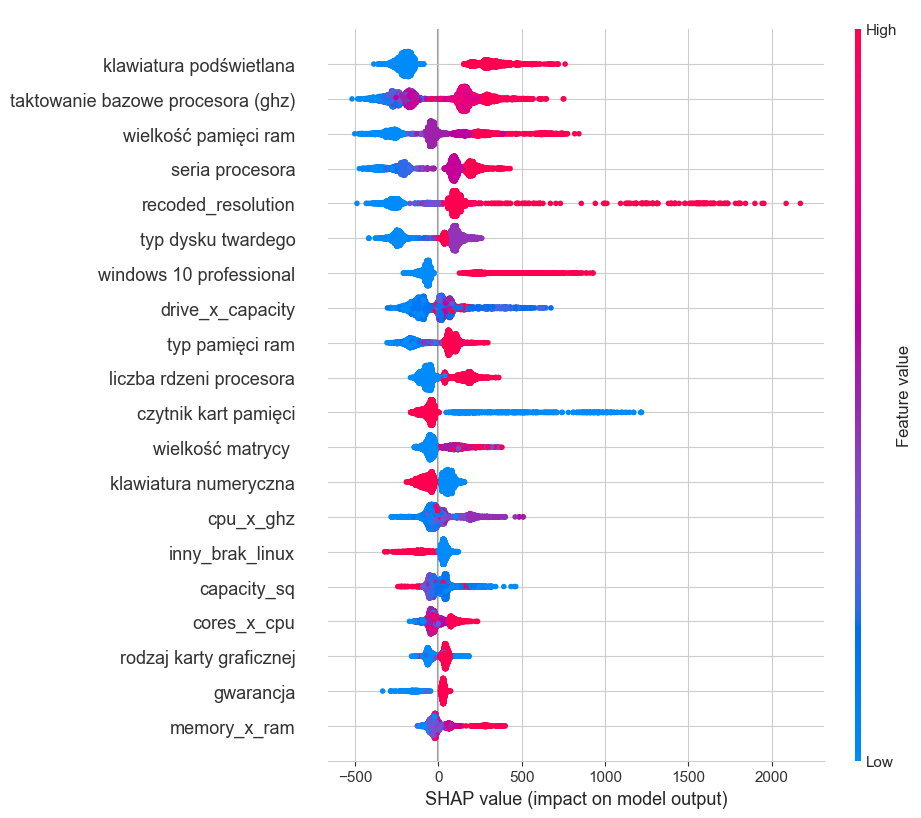

In [796]:
shap.initjs()
model_final.fit(X_train_transformed, y_train)
explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed)

In [801]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

scoring: Dict[str, float] = {
    'MAE': 'neg_mean_absolute_error', 
    'MSE': 'neg_mean_squared_error',
    'R2':'r2',
    'MAPE': mape_scorer
}

metrics_dict: Dict[str, List[float]] = {
    'mae': [], 
    'rmse': [], 
    'r2': [], 
    'mape': [], 
    'rmse_error': []
    }

counter: int = 0
    
for i in (1e6*np.random.rand(100)).astype(int):

    cv = cross_validate(
        model_final,
        X_train_transformed,
        y_train,
        scoring=scoring,
        cv=KFold(10, random_state=i, shuffle=True),
        verbose=0,
        return_train_score=True,
        n_jobs=-1
    )
    
    mae: float = np.mean(cv['test_MAE']*(-1))
    rmse: float = np.mean(np.sqrt(cv['test_MSE']*(-1)))
    r2: float = np.mean(cv['test_R2'])
    mape: float  = np.mean(cv['test_MAPE']*(-1))
    
    rmse_train: float = np.mean(np.sqrt(cv['train_MSE']*(-1)))
    
    rmse_error: float = (rmse-rmse_train)/rmse_train
    
    metrics_dict['mae'].append(mae)
    metrics_dict['rmse'].append(rmse)
    metrics_dict['r2'].append(r2)
    metrics_dict['mape'].append(mape)
    metrics_dict['rmse_error'].append(rmse_error)
    
    counter +=1
    
    if counter % 10 == 0:
        print(counter)

10
20
30
40
50
60
70
80
90
100


Text(0.5, 1.0, '10 fold CV, 100 repeats with different seeds')

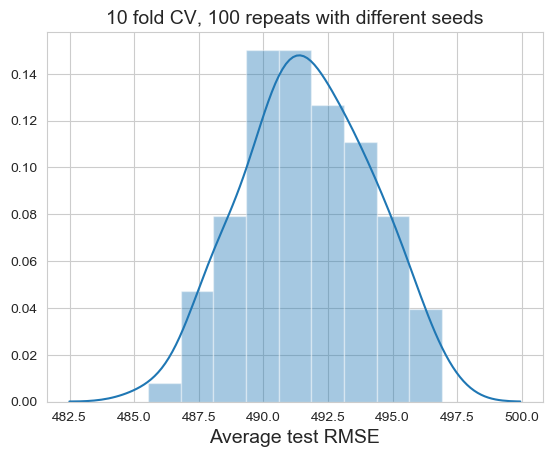

In [802]:
sns.distplot(metrics_dict['rmse'], norm_hist=True)
plt.xlabel('Average test RMSE', fontsize=14)
plt.title('10 fold CV, 100 repeats with different seeds', fontsize=14)

Text(0.5, 1.0, '10 fold CV, 100 repeats with different seeds')

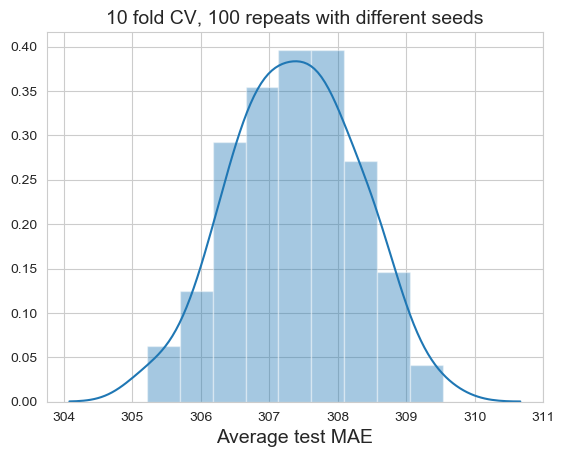

In [803]:
sns.distplot(metrics_dict['mae'], norm_hist=True)
plt.xlabel('Average test MAE', fontsize=14)
plt.title('10 fold CV, 100 repeats with different seeds', fontsize=14)

Text(0.5, 1.0, '10 fold CV, 100 repeats with different seeds')

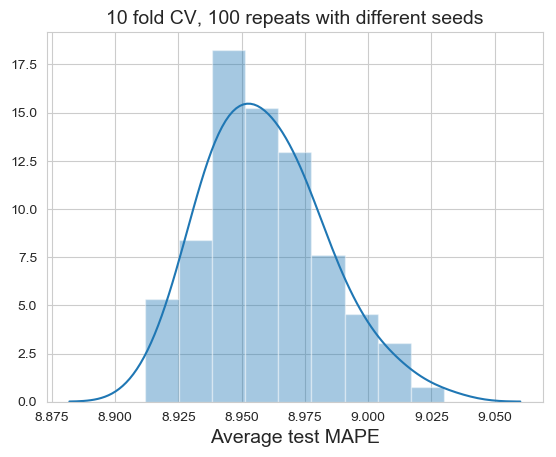

In [804]:
sns.distplot(metrics_dict['mape'], norm_hist=True)
plt.xlabel('Average test MAPE', fontsize=14)
plt.title('10 fold CV, 100 repeats with different seeds', fontsize=14)

Text(0.5, 1.0, '10 fold CV, 100 repeats with different seeds')

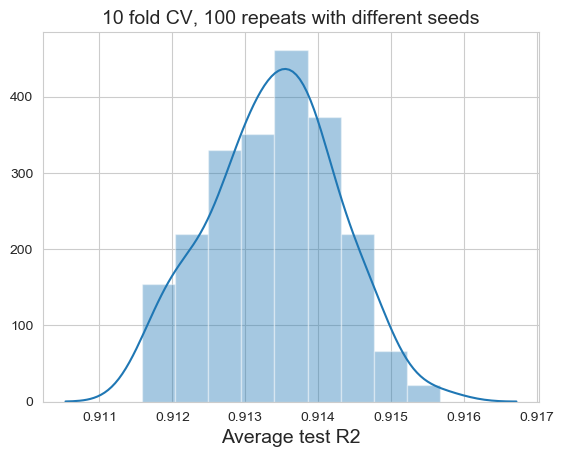

In [805]:
sns.distplot(metrics_dict['r2'], norm_hist=True)
plt.xlabel('Average test R2', fontsize=14)
plt.title('10 fold CV, 100 repeats with different seeds', fontsize=14)

### Scoring

In [812]:
scoring_raw = pd.read_json("./hidden-Xs.json").reset_index(drop=True)

In [813]:
scoring_transformed = data_pipeline.transform(scoring_raw)

In [815]:
scoring_raw['buynow_price'] = model_final.predict(scoring_transformed)

In [818]:
scoring_raw.sort_values(by='buynow_price', ascending=False).head()

,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy,buynow_price
873,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,16 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.9,intel core i7,nowy,512.0,producenta,"15"" - 15.9""",10039.856340
325,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps, lan 1...",1920 x 1080,4,16 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",None,NaN,intel core i7,nowy,512.0,producenta,"15"" - 15.9""",9997.190993
3011,grafika zintegrowana,"[wi-fi, bluetooth, modem 3g (wwan), modem 4g (...",2560 x 1440,2,16 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura podświetlana]","[czytnik kart pamięci, kamera, głośniki, mikro...",None,NaN,intel core i7,nowy,512.0,producenta,"14"" - 14.9""",9856.635589
3682,grafika dedykowana,"[wi-fi 802.11 b/g/n/ac, bluetooth, lan 10/100/...",2560 x 1440,4,16 gb,[windows 10 professional],None,"[klawiatura, touchpad, klawiatura podświetlana]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,NaN,intel core i7,nowy,512.0,producenta,"14"" - 14.9""",9837.050711
2608,grafika zintegrowana,"[bluetooth, lan 10/100 mbps, modem 4g (lte)]",3840 x 2160,2,16 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura podświetlana]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.7,intel core i7,nowy,512.0,producenta,"15"" - 15.9""",9424.713351


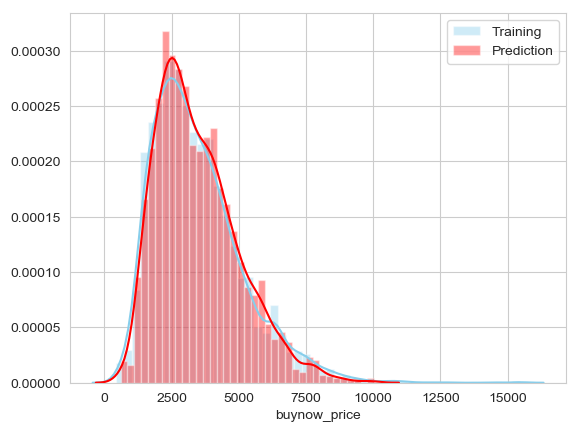

In [825]:
sns.distplot(y_train, color="skyblue", label="Training")
sns.distplot(scoring_raw.buynow_price , color="red", label="Prediction")
plt.legend()

In [830]:
scoring_raw.loc[:, 'buynow_price'].to_json('scoring.json', orient='columns')